# Edelweiss: Data Analysis and Modelling Part 3 - XG Boost Regressor with Linear Regression Residuals

We will be feeding residuals of finalised linear regression model to XG Boost Regresssor as dependent variable.

## 1. Data Preprocessing

In [1]:
import pandas as pd
import numpy as np

df=pd.read_csv('edw_launch_price_data_with_am_sp_word_embed.csv')
df.head()

,pid,b1,b2,b3,b4,b5,b6,b7,b8,zone,...,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25
0,1,106.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,Zone A,...,-0.422871,-0.789669,-0.659173,0.189961,0.335592,1.264041,0.054089,-0.131723,-0.580872,0.412611
1,2,NaN,98.0,52.0,NaN,NaN,NaN,NaN,NaN,Zone A,...,-0.056276,-0.577943,-0.373556,-0.023348,0.538932,0.988884,-0.303059,0.348402,-0.405855,0.458890
2,3,NaN,98.0,52.0,NaN,NaN,NaN,NaN,NaN,Zone A,...,-0.055074,-0.553753,-0.389509,-0.025317,0.572751,1.003029,-0.347910,0.379972,-0.367028,0.492925
3,6,107.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,Zone A,...,-0.174178,-0.400852,-0.209210,-0.201405,0.652291,1.168787,0.021800,0.150187,-0.344659,0.357670
4,7,1.0,22.0,10.0,NaN,NaN,NaN,NaN,NaN,Zone A,...,-0.063372,-0.468529,-0.364467,-0.108515,0.692411,1.022727,-0.269232,0.352715,-0.367375,0.468766


#### 1.1 Creation of micro_market number and developer_number columns

In [2]:
df['micro_market_number']=df['micro_market'].str.extract('(\d+)')
df['developer_number']=df['developer'].str.extract('(\d+)')
df['project_number']=df['project'].str.extract('(\d+)')

#### 1.2 Extract launch year from launch date

In [3]:
df['launch_year'] = pd.DatetimeIndex(df['launch_date']).year

#### 1.3 Log-transformation of wap into log_wap

In [4]:
df['log_wap'] = np.log(df['wap'])

#### 1.4 Recoding of proj_bedrooms

In [5]:
df['proj_bedrooms'].value_counts()

1,2              1075
1                 519
1,2,3             296
2,3               241
2                 161
3                  56
2,3,4              51
3,4                39
1,2,3,4            33
3,2                17
4                  16
3,1,2              14
1,3                12
3,4,5              10
1,2,4               9
1,2,3,5             8
2,4                 6
2,3,5               6
1,3,4               6
2,3,4,5             5
3,5                 4
4,2,3               3
1,2,3,4,5           3
4,5                 3
3,4,2               3
4,3                 3
1,3,4,5             2
2,3,4,5,1           1
2,5                 1
2,3,4,1             1
4,1,3               1
4,1,2,3             1
3,1                 1
6,2,3,4,5           1
6,1,2,3,4           1
4,2                 1
4,5,8               1
2,3,8               1
1,5,8               1
3,6                 1
5,2,3,4             1
2,3,5,1             1
3,4,6               1
4,5,6,3             1
6,7,1,2,3,4,5       1
1,2,4,5   

In [6]:
new_tags=['1,2,3','1,2,3,4','1,2,3,4','1,3','2,3','2,4','1,3,4','1,2,3,4,5','2,3,4,5','3,4','1,2,3,5','2,3,4','2,3,4']
old_tags=['3,1,2','4,1,2,3','2,3,4,1','3,1','3,2','4,2','4,1,3','2,3,4,5,1','5,2,3,4','4,3','2,3,5,1','4,2,3','3,4,2']

df["proj_bedrooms_clean"]=df["proj_bedrooms"]
df["proj_bedrooms_clean"]=df["proj_bedrooms_clean"].replace(old_tags,new_tags)
df["proj_bedrooms_clean"]=df["proj_bedrooms_clean"].str.split(',').str[0]
df["proj_bedrooms_clean"]=df["proj_bedrooms_clean"].replace(['1','2','3','4','5','6'],['1 and more','2 and more','3 and more','4 and more','5 and more','6 and more'])
df["proj_bedrooms_clean"].value_counts()

1 and more    1985
2 and more     498
3 and more     114
4 and more      21
6 and more       3
Name: proj_bedrooms_clean, dtype: int64

In [7]:
cols=['zone', 'micro_market_number', 'developer_number','project_number','wap','log_wap','proj_bedrooms_clean','unit_type','proj_launched_units','launch_year','construction_status','max_size','min_size','b1','b2','b3','b4','b5','b6','b7','b8']
df1=pd.DataFrame(df[cols]).fillna("0")
w_emb=df.loc[:,'V1':'V25']
df1=pd.concat([df1, w_emb], axis=1)
df1.head()

,zone,micro_market_number,developer_number,project_number,wap,log_wap,proj_bedrooms_clean,unit_type,proj_launched_units,launch_year,...,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25
0,Zone A,1,1,1,14464.0000,9.579418,1 and more,Apartment,111,2015,...,-0.422871,-0.789669,-0.659173,0.189961,0.335592,1.264041,0.054089,-0.131723,-0.580872,0.412611
1,Zone A,1,2,2,13982.0000,9.545526,2 and more,Apartment,150,2014,...,-0.056276,-0.577943,-0.373556,-0.023348,0.538932,0.988884,-0.303059,0.348402,-0.405855,0.458890
2,Zone A,1,2,3,13982.0000,9.545526,2 and more,Apartment,150,2014,...,-0.055074,-0.553753,-0.389509,-0.025317,0.572751,1.003029,-0.347910,0.379972,-0.367028,0.492925
3,Zone A,1,5,6,12857.0000,9.461644,1 and more,Apartment,120,2016,...,-0.174178,-0.400852,-0.209210,-0.201405,0.652291,1.168787,0.021800,0.150187,-0.344659,0.357670
4,Zone A,1,7,8,16981.5758,9.739884,1 and more,Apartment,33,2015,...,-0.063372,-0.468529,-0.364467,-0.108515,0.692411,1.022727,-0.269232,0.352715,-0.367375,0.468766


#### 1.5 Type Conversion


In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2621 entries, 0 to 2620
Data columns (total 46 columns):
zone                   2621 non-null object
micro_market_number    2621 non-null object
developer_number       2621 non-null object
project_number         2621 non-null object
wap                    2621 non-null float64
log_wap                2621 non-null float64
proj_bedrooms_clean    2621 non-null object
unit_type              2621 non-null object
proj_launched_units    2621 non-null int64
launch_year            2621 non-null int64
construction_status    2621 non-null object
max_size               2621 non-null float64
min_size               2621 non-null float64
b1                     2621 non-null object
b2                     2621 non-null object
b3                     2621 non-null object
b4                     2621 non-null object
b5                     2621 non-null object
b6                     2621 non-null object
b7                     2621 non-null object
b8         

In [9]:
def type_converter (dataframe, col_name, data_type):
    dataframe[col_name]=dataframe[col_name].astype(data_type)

In [10]:
for i in ['b1','b2','b3','b4','b5','b6','b7','b8']:
    type_converter (df1, i, 'int')

In [11]:
for i in ['zone','micro_market_number','proj_bedrooms_clean','project_number','unit_type','launch_year','construction_status']:
    type_converter (df1, i, 'category')

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2621 entries, 0 to 2620
Data columns (total 46 columns):
zone                   2621 non-null category
micro_market_number    2621 non-null category
developer_number       2621 non-null object
project_number         2621 non-null category
wap                    2621 non-null float64
log_wap                2621 non-null float64
proj_bedrooms_clean    2621 non-null category
unit_type              2621 non-null category
proj_launched_units    2621 non-null int64
launch_year            2621 non-null category
construction_status    2621 non-null category
max_size               2621 non-null float64
min_size               2621 non-null float64
b1                     2621 non-null int32
b2                     2621 non-null int32
b3                     2621 non-null int32
b4                     2621 non-null int32
b5                     2621 non-null int32
b6                     2621 non-null int32
b7                     2621 non-null int32
b8 

#### 1.6 Creation of bedrooms by typology columns


In [13]:
df1['bp1']=df1['b1']/df1['proj_launched_units']
df1['bp2']=df1['b2']/df1['proj_launched_units']
df1['bp3']=df1['b3']/df1['proj_launched_units']
df1['bp4']=df1['b4']/df1['proj_launched_units']
df1['bp5']=df1['b5']/df1['proj_launched_units']
df1['bp6']=df1['b6']/df1['proj_launched_units']
df1['bp7']=df1['b7']/df1['proj_launched_units']
df1['bp8']=df1['b8']/df1['proj_launched_units']

In [14]:
df1['bp48']=df1['bp4']+df1['bp5']+df1['bp6']+df1['bp7']+df1['bp8']
df1['bp58']=df1['bp5']+df1['bp6']+df1['bp7']+df1['bp8']

#### 1.7 rv_size column


In [15]:
df1['size_range'] = df1['max_size'] - df1['min_size']
df1['size_rv'] = df1['size_range'] / df1['min_size']

In [16]:
df1.head()

,zone,micro_market_number,developer_number,project_number,wap,log_wap,proj_bedrooms_clean,unit_type,proj_launched_units,launch_year,...,bp3,bp4,bp5,bp6,bp7,bp8,bp48,bp58,size_range,size_rv
0,Zone A,1,1,1,14464.0000,9.579418,1 and more,Apartment,111,2015,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,432.27,1.383353
1,Zone A,1,2,2,13982.0000,9.545526,2 and more,Apartment,150,2014,...,0.346667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,272.43,0.372748
2,Zone A,1,2,3,13982.0000,9.545526,2 and more,Apartment,150,2014,...,0.346667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,272.43,0.372748
3,Zone A,1,5,6,12857.0000,9.461644,1 and more,Apartment,120,2016,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,320.55,1.187398
4,Zone A,1,7,8,16981.5758,9.739884,1 and more,Apartment,33,2015,...,0.303030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1035.43,1.519184


## 2. Data and Cluster Analysis

### 2.1 Clustering of Micromarkets

1. K-Means Clustering based on mean of wap for every micromarket

2. Assigning cluster numbers to respective micro_markets

3. Counting number of projects and micromarkets in every cluster


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")
sns.set_color_codes("dark")

In [18]:
mm_prices=df1.groupby('micro_market_number')['wap'].mean()
mm_prices

micro_market_number
1      16070.897978
10     12709.734924
100     6730.000000
101     4800.454082
102     7601.348358
104     4550.000000
105     9666.666667
106     5561.967821
107     8028.775714
108    10951.648586
109     4281.954455
11     13484.938329
110     5600.885779
111    15000.000000
112     3487.000000
113     4788.333333
114    10016.946792
115    24283.307556
116    49078.461538
118    36898.200000
119    34324.333333
12     12687.445504
120    33074.574463
121    19744.017888
122    38020.914456
123    28022.157103
124    31466.083000
13     14725.692669
14      3217.645000
15      3230.666667
           ...     
69      3134.751107
7      14843.527256
70      2900.637781
72      4615.802286
73      4877.616544
75     17564.462999
76     17072.694050
77     18741.930000
79     17901.507612
8      16130.349347
80     20000.000000
81     50000.000000
82     24814.456483
84     31521.000000
85     31160.750000
86     24508.750000
87     26954.200000
88     29835.340446


The number of micromarkets is too large to be used as a variable for regression model. Let's cluster micromarkets in terms of prices. Let us try kmeans clustering.

In [19]:
mm=mm_prices.values
mm=mm.reshape(-1, 1)
mm.shape

(113, 1)

In [20]:
from sklearn.cluster import KMeans

#clustering formula
kmeans = KMeans(n_clusters=20, n_init=100, max_iter=1000,n_jobs=5)

# get the clusters
kmm = kmeans.fit_predict(mm)

#clustering metric
from sklearn.metrics import silhouette_score
print("Silhoutte Score of Micromarket Clusters:", silhouette_score(mm, kmm))

Silhoutte Score of Micromarket Clusters: 0.659594734571081


In [21]:
#cluster dataframe
kmm=pd.DataFrame(kmm)
kmm.columns=['mm_cluster']

#cluster number and number of projects for every micromarket
mm_proj=df1.groupby('micro_market_number')['project_number'].count().reset_index()
mm_proj=pd.concat([mm_proj, kmm],axis=1)
mm_proj

,micro_market_number,project_number,mm_cluster
0,1,49,2
1,10,12,9
2,100,5,13
3,101,49,0
4,102,33,13
5,104,2,0
6,105,3,5
7,106,55,19
8,107,7,13
9,108,14,18


In [22]:
# Dictionary mapping micromarket number with cluster numbers
market_cluster = dict(zip(mm_proj['micro_market_number'], mm_proj['mm_cluster']))

In [23]:
# Create a new column in the dataset indicating cluster numbers, initialised with micromarket numbers
df1['mm_cluster']=df1['micro_market_number']
# Map cluster numbers to their respective micromarket numbers 
df1['mm_cluster']=df1['mm_cluster'].map(market_cluster)
df1['mm_cluster'].value_counts()

7     559
19    347
18    230
14    218
16    202
0     192
2     187
9     129
13    126
12    124
6      87
1      46
4      42
11     32
8      30
15     23
5      19
3      14
17      7
10      7
Name: mm_cluster, dtype: int64

### 2.2 Clustering Developers

Number of developers are too large to be used as predictors. It is better to cluster them.

Clustering done based on agglomerative clustering using Ward's linkage.

In [24]:
devn_prices=df1.groupby('developer_number')['wap'].mean()
devn_prices

developer_number
1       14464.000000
10      12610.000000
100     15750.000000
1000     3000.000000
1002     4500.000000
1003     4171.000000
1004     4500.000000
1006     5650.000000
1007     5662.000000
1008     5657.580600
101     18500.000000
1011     9642.000000
1012     5000.000000
1014    10850.000000
1017     4751.106867
1018     7500.000000
1019     9160.000000
102      8949.836325
1020     7857.000000
1021     4609.000000
1023     4875.000000
1025     4532.000000
1026     5303.000000
1029     3958.500000
1030     5006.879833
1031    10000.000000
1032     3999.000000
1033     4753.500000
1035     4821.884067
1037     4408.000000
            ...     
947      3104.000000
949      3750.000000
952      5107.000000
956      2900.000000
957      3578.000000
959      3250.000000
96      16465.620000
960     10791.333333
962      4500.000000
963      3400.000000
965      5178.000000
967      5100.000000
968      3750.000000
970      4000.000000
971     12330.000000
972      4339.000

In [25]:
devn=devn_prices.values # Reshape the array consisting of data with one feature into one column only 
devn=devn.reshape(-1, 1)
devn.shape

(1504, 1)

[Text(0, 0.5, 'Inter-cluster distance'), Text(0.5, 1.0, 'Dendrogram')]

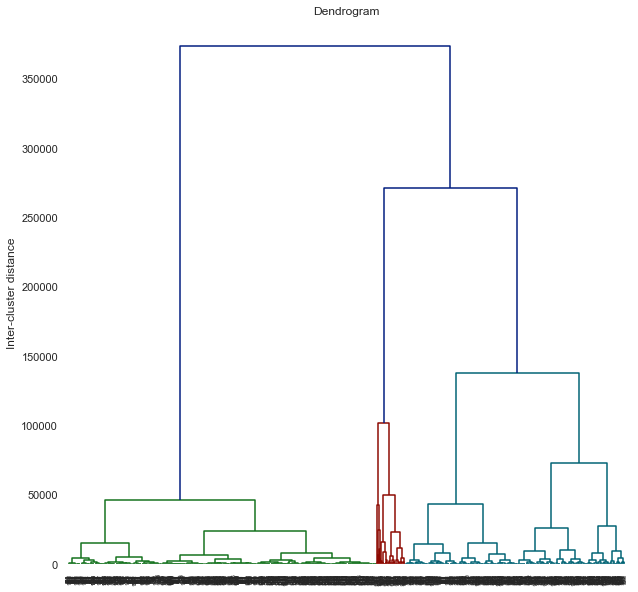

In [26]:
# for visualisation for hierarchal cluster linkage
from scipy.cluster.hierarchy import dendrogram, linkage

links = linkage(devn, method='ward', metric='euclidean')

fig, ax = plt.subplots(figsize=(10, 10))
dendrogram(links, ax=ax)

ax.set(title='Dendrogram', ylabel='Inter-cluster distance')

In [27]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=20,linkage='ward')
clusters_agg = agg.fit_predict(devn)

print("Silhoutte Score of Developer Clusters:", silhouette_score(devn, clusters_agg))

Silhoutte Score of Developer Clusters: 0.5551048139920645


In [28]:
#cluster dataframe
clusters_agg =pd.DataFrame(clusters_agg)
clusters_agg .columns=['dev_cluster']

#cluster number and number of projects for every micromarket
dev_proj=df1.groupby('developer_number')['project_number'].count().reset_index()
dev_proj=pd.concat([dev_proj, clusters_agg ],axis=1)
dev_proj

,developer_number,project_number,dev_cluster
0,1,1,16
1,10,1,3
2,100,2,11
3,1000,1,4
4,1002,1,13
5,1003,1,13
6,1004,1,13
7,1006,1,8
8,1007,1,8
9,1008,1,8


In [29]:
# Dictionary mapping micromarket number with cluster numbers
dev_cluster = dict(zip(dev_proj['developer_number'], dev_proj['dev_cluster']))

In [30]:
# Create a new column in the dataset indicating cluster numbers, initialised with micromarket numbers
df1['dev_cluster']=df1['developer_number']
# Map cluster numbers to their respective micromarket numbers 
df1['dev_cluster']=df1['dev_cluster'].map(dev_cluster)
print('value counts of developer clusters')
df1['dev_cluster'].value_counts()

value counts of developer clusters


4     491
13    412
8     246
11    198
6     190
3     181
17    172
18    154
2     147
16    138
10    125
5      74
14     24
7      21
9      16
1      16
12      6
15      6
0       3
19      1
Name: dev_cluster, dtype: int64

In [31]:
df1['dev_cluster']=df1['dev_cluster'].replace([19,0,12],[15,15,15])
df1['dev_cluster'].value_counts()

4     491
13    412
8     246
11    198
6     190
3     181
17    172
18    154
2     147
16    138
10    125
5      74
14     24
7      21
15     16
9      16
1      16
Name: dev_cluster, dtype: int64

## 3. Calcuting Residuals of Finalised Linear Regression Model

In [32]:
def calculate_vif (inc, dataframe): # Function for calculating and returning VIF values
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from statsmodels.tools.tools import add_constant
    
    df_vif=dataframe[inc]
    df_vifx = add_constant(df_vif)
    print('--Calculated VIF values--')
    return (pd.Series([variance_inflation_factor(df_vifx.values, i) for i in range(df_vifx.shape[1])], index=df_vifx.columns))

In [33]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

mod = smf.ols(formula='log_wap ~ C(mm_cluster) + b2 + bp1 + bp3 + bp4 + bp58 + size_rv + V4 + V5 + V6 + V7 + V8 + V12 + V13 + V16 + V17 + V23 + V24', data=df1).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                log_wap   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     867.5
Date:                Sat, 16 Mar 2019   Prob (F-statistic):               0.00
Time:                        21:22:37   Log-Likelihood:                 313.85
No. Observations:                2621   AIC:                            -553.7
Df Residuals:                    2584   BIC:                            -336.5
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               8.4927    

In [34]:
def residual_log (model, dataframe, residual_log, residual):
    # Function To Compute and return residual summary statistics for a model
    predicted_lwap = model.predict()
    predicted_wap=np.exp(predicted_lwap)
    dataframe[residual_log]=dataframe['log_wap'] - predicted_lwap
    dataframe[residual]=dataframe['wap'] - predicted_wap
    return (dataframe[residual_log].describe(), print('median:  ',dataframe[residual_log].median()))

In [35]:
def percentage_error_projects (dataframe, residual, percentage_error,percentage_error_interval):
    #Calculate percentage error w.r.t wap
    dataframe[percentage_error]=(dataframe[residual]/dataframe['wap'])*100
    #Split percentage error into equal intervals
    dataframe[percentage_error_interval] = pd.cut(dataframe[percentage_error], bins=[-float("inf"),-30,-20,-10,0,10,20,30,float("inf")])
    # How many projects in each interval of wap?
    grouped_df = dataframe.groupby(percentage_error_interval)['project_number'].count().reset_index()
    # Percentage of projects under each interval
    grouped_df['percentage_projects']=(grouped_df['project_number']/grouped_df['project_number'].sum())*100
    return (grouped_df)  

In [36]:
residual_log (mod, df1, 'residual_log_mod','residual_mod') # Residual statistics for log-transformed proposed base model

median:   0.003237368314518818


(count    2.621000e+03
 mean     9.416182e-14
 std      2.147043e-01
 min     -1.208032e+00
 25%     -1.229116e-01
 50%      3.237368e-03
 75%      1.192870e-01
 max      1.166836e+00
 Name: residual_log_mod, dtype: float64, None)

In [37]:
percentage_error_projects (df1, 'residual_mod', 'percentage_error_mod','percentage_error_interval_mod')

,percentage_error_interval_mod,project_number,percentage_projects
0,"(-inf, -30.0]",237,9.042350
1,"(-30.0, -20.0]",196,7.478062
2,"(-20.0, -10.0]",363,13.849676
3,"(-10.0, 0.0]",495,18.885921
4,"(0.0, 10.0]",608,23.197253
5,"(10.0, 20.0]",418,15.948111
6,"(20.0, 30.0]",192,7.325448
7,"(30.0, inf]",112,4.273178


In [38]:
# Mean Absolute Percentage Error of log-transformed base model
np.absolute(df1['percentage_error_mod']).mean()

16.177160729828856

In [39]:
# Split up wap into intervals
df1['wap_interval'] = pd.cut(df1['wap'], bins=[0,5e+3,1e+4,3e+4,9e+4]) 
df1['wap_interval'].value_counts()

(0.0, 5000.0]         1017
(10000.0, 30000.0]     927
(5000.0, 10000.0]      565
(30000.0, 90000.0]     112
Name: wap_interval, dtype: int64

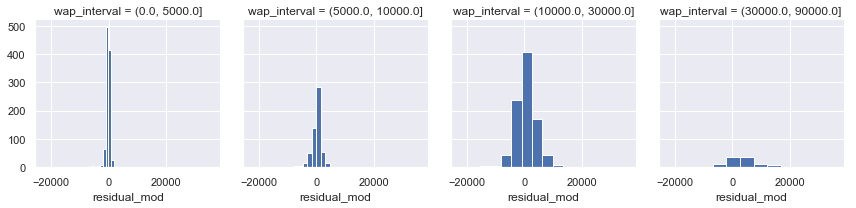

In [40]:
sns.FacetGrid(df1, col="wap_interval").map(plt.hist, "residual_mod")

## 4. Exploratory Data Analysis With Residuals of Finalised Regression Linearised Models

### 4.1 Residual Distribution of Linear Model Across Different Categorical Variables

Categories with higher frequency counts have smaller variations in price prediction errors overall.

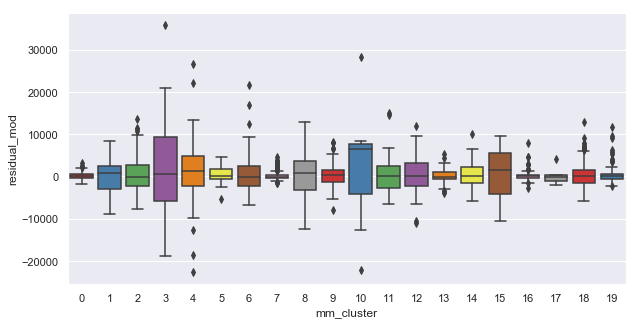

In [41]:
f, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x="mm_cluster", y="residual_mod", data=df1,palette='Set1')

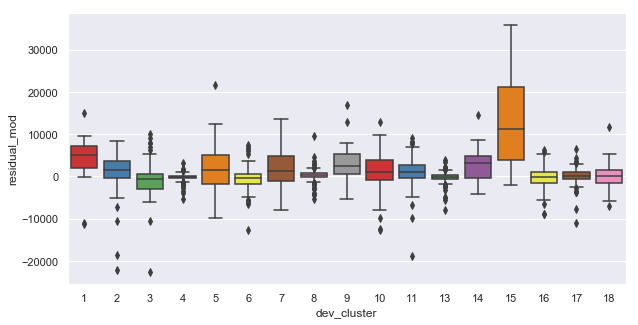

In [42]:
f, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x="dev_cluster", y="residual_mod", data=df1,palette='Set1')

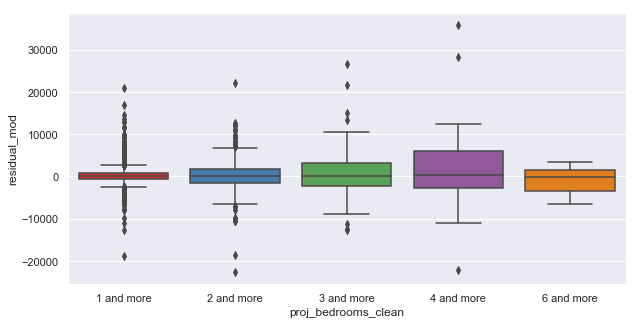

In [43]:
f, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x="proj_bedrooms_clean", y="residual_mod", data=df1,palette='Set1')

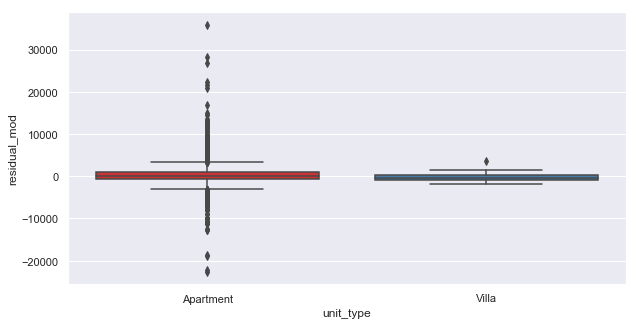

In [44]:
f, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x="unit_type", y="residual_mod", data=df1,palette='Set1')

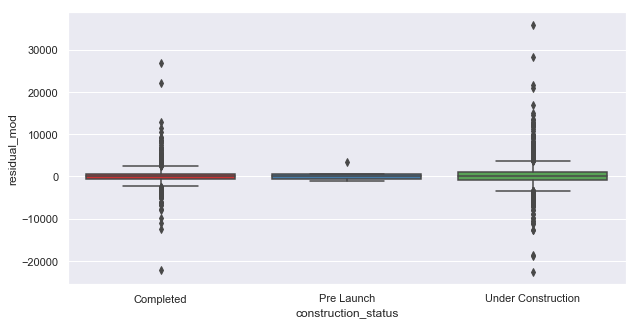

In [45]:
f, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x="construction_status", y="residual_mod", data=df1,palette='Set1')

### 4.2 Predictive Power of Linear Model Over Years Across Different Categorical Variables

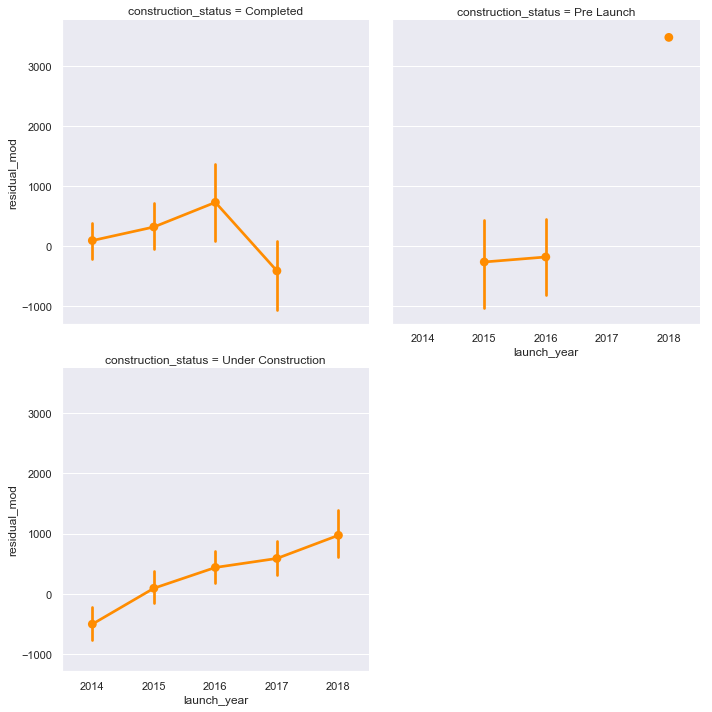

In [46]:
sns.catplot(x="launch_year", y="residual_mod", col="construction_status",col_wrap=2, data=df1, kind="point", height=5, aspect=1, color='darkorange')

Predictive power of models for different construction statuses of flats are shown to be decreasing.

There are a lot of outlier cases for residuals of completed flats. Its error bars are longest. 

The residuals for flats under construction show greater variation in prices and thus residuals as well. No wonder its residuals shows sharpest rise across years.

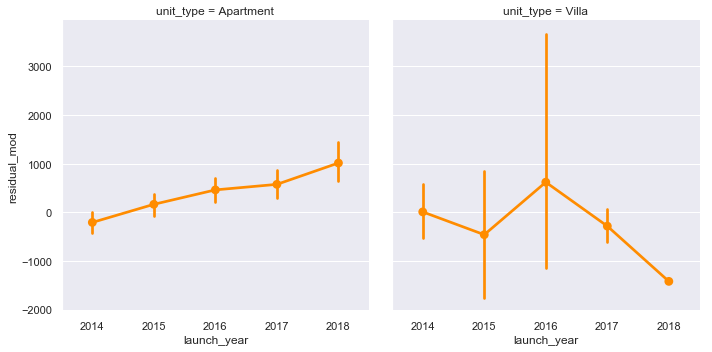

In [47]:
sns.catplot(x="launch_year", y="residual_mod", col="unit_type",col_wrap=2, data=df1, kind="point", height=5, aspect=1, color='darkorange')

The linear regression model is better able to predict prices of villas compared to apartments. Apartments show lesser variations in price prediction errors as its frequency is higher than villas.

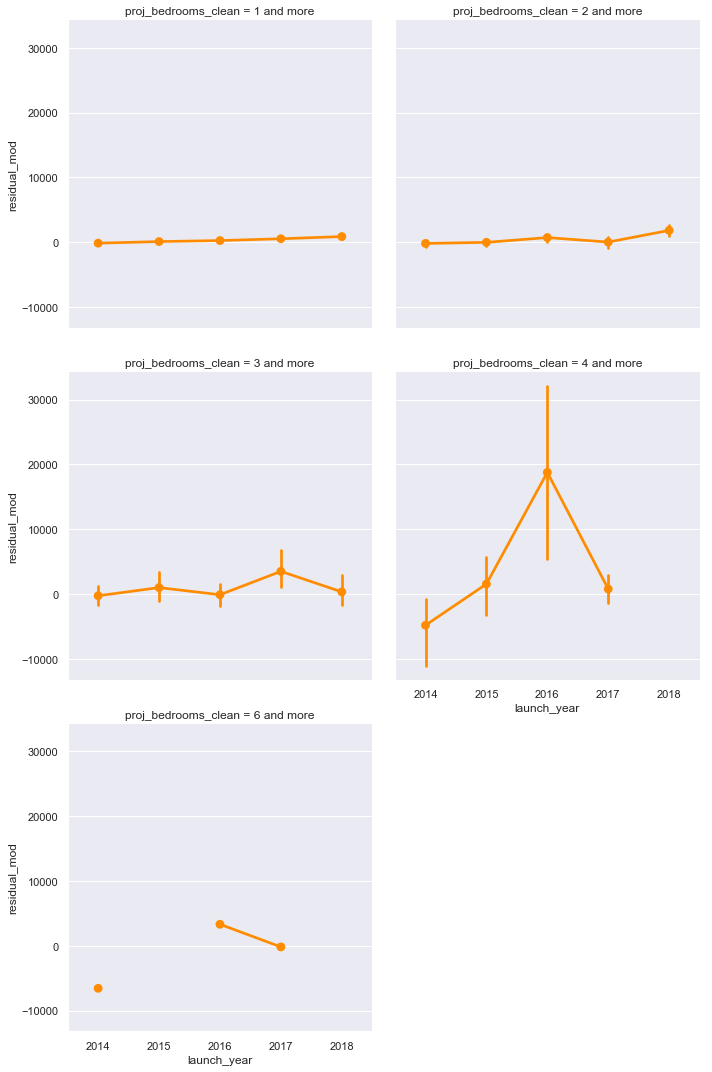

In [48]:
sns.catplot(x="launch_year", y="residual_mod", col="proj_bedrooms_clean",col_wrap=2, data=df1, kind="point", height=5, aspect=1, color='darkorange')

Due to large frequencies of 1 and 2 or more bedroom flats, the model is able to predict their prices with lesser errors compared to those with higher number of bedrooms.

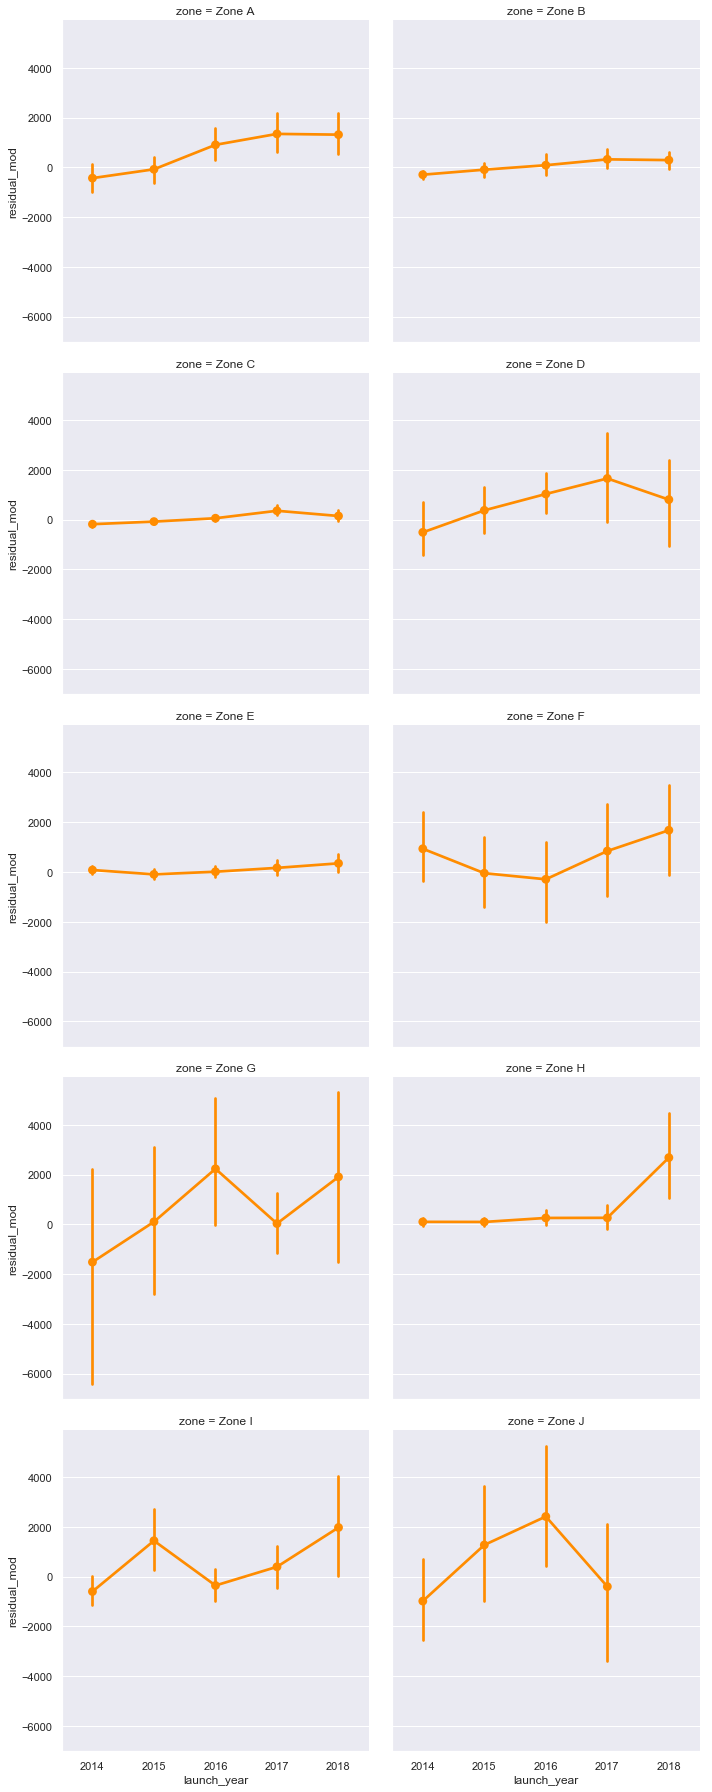

In [49]:
sns.catplot(x="launch_year", y="residual_mod", col="zone",col_wrap=2, data=df1, kind="point", height=5, aspect=1, color='darkorange')

Overall, predictive power of models across different zones are decreasing over years due to increasing value of residuals.

### 4.3 How Percentage Error of Linear Model Varies Across Prices


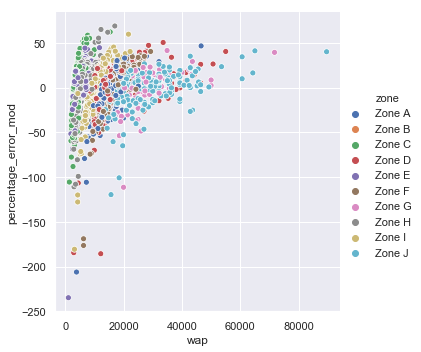

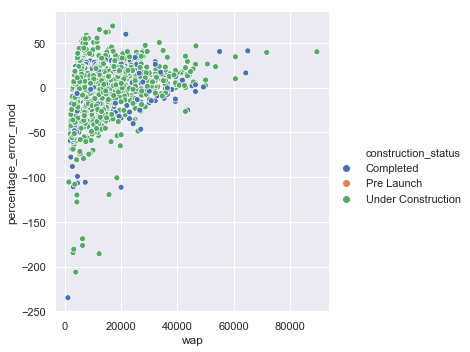

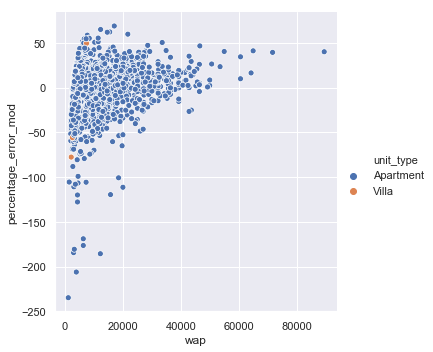

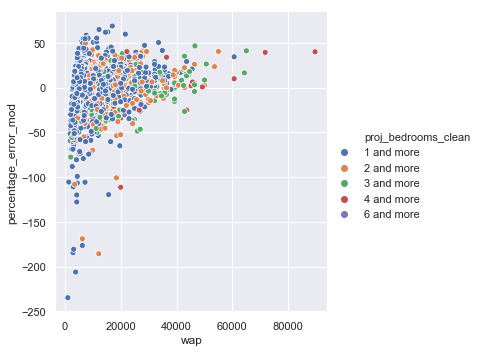

In [50]:
# Scatterplots of percentage error of finalised linear regression model against residual amount
sns.relplot(x="wap", y="percentage_error_mod", hue="zone", data=df1)
sns.relplot(x="wap", y="percentage_error_mod", hue="construction_status", data=df1)
sns.relplot(x="wap", y="percentage_error_mod", hue="unit_type", data=df1)
sns.relplot(x="wap", y="percentage_error_mod", hue="proj_bedrooms_clean", data=df1)

Most of the projects can be classified under lower category of prediction errors at lower prices.

## 5. XGBoost Regressor Using All Features

In [51]:
def label_encoder(dataframe, col_name): # Function for label encoding categorical variables
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(dataframe[col_name].unique())
    dataframe[col_name] = le.transform(dataframe[col_name])

In [52]:
include=['residual_mod','mm_cluster','dev_cluster','b1','b2','b3','b4','b5','b6','b7','b8','bp1','bp3','bp4','bp5','bp6','bp7','bp8','bp48','bp58','min_size','max_size','size_rv','unit_type','construction_status','proj_bedrooms_clean','proj_launched_units','launch_year','size_range','V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25']
df2=pd.DataFrame(df1[include])

df2['launch_year']=df2['launch_year'].astype('int')
for i in ['unit_type','construction_status','proj_bedrooms_clean']: # Label-encoding of amenities features
    label_encoder(df2, i)
    
df2.head()

,residual_mod,mm_cluster,dev_cluster,b1,b2,b3,b4,b5,b6,b7,...,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25
0,5.333808,2,16,106,5,0,0,0,0,0,...,-0.422871,-0.789669,-0.659173,0.189961,0.335592,1.264041,0.054089,-0.131723,-0.580872,0.412611
1,-2256.206867,2,16,0,98,52,0,0,0,0,...,-0.056276,-0.577943,-0.373556,-0.023348,0.538932,0.988884,-0.303059,0.348402,-0.405855,0.458890
2,-1917.604198,2,16,0,98,52,0,0,0,0,...,-0.055074,-0.553753,-0.389509,-0.025317,0.572751,1.003029,-0.347910,0.379972,-0.367028,0.492925
3,-1289.240782,2,3,107,13,0,0,0,0,0,...,-0.174178,-0.400852,-0.209210,-0.201405,0.652291,1.168787,0.021800,0.150187,-0.344659,0.357670
4,589.981900,2,11,1,22,10,0,0,0,0,...,-0.063372,-0.468529,-0.364467,-0.108515,0.692411,1.022727,-0.269232,0.352715,-0.367375,0.468766


In [53]:
from sklearn.model_selection import train_test_split

target = 'residual_mod'
features = df2.columns != target
x = df2.loc[:,features]
y = df2[target]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=8)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1965, 53) (656, 53) (1965,) (656,)


In [54]:
import xgboost as xgb

xg_reg_all=xgb.XGBRegressor(base_score=0.5,booster='gbtree', objective='reg:linear',n_estimators=1500,learning_rate=1.195,reg_lambda=0,reg_alpha=1200,max_depth=5)
xg_reg_all.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=1.195, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=1200, reg_lambda=0, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [55]:
from sklearn.model_selection import cross_validate

# cross validate
scores_xgreg_all = cross_validate(xg_reg_all, x_train, y_train, cv=5,
                        return_train_score=True,
                        return_estimator=False)
scores_xgreg_all=pd.DataFrame(scores_xgreg_all)
scores_xgreg_all

,fit_time,score_time,test_score,train_score
0,2.142543,0.008341,-0.516286,0.999440
1,2.296493,0.010079,-1.715465,0.999505
2,2.059148,0.008057,-0.918906,0.999529
3,1.854014,0.000000,-1.434444,0.999472
4,1.935092,0.015623,-0.581224,0.999449


In [56]:
print('Mean Test Score of XG Boost Regressor using  features in finalised model: ', scores_xgreg_all['test_score'].mean())
print('Mean Train Score of XG Boost Regressor using features in finalised model: ', scores_xgreg_all['train_score'].mean())

Mean Test Score of XG Boost Regressor using  features in finalised model:  -1.0332647930665115
Mean Train Score of XG Boost Regressor using features in finalised model:  0.9994789414261142


In [57]:
def model_R2 (model,x_testdataframe,y_testdataframe):
    from sklearn.metrics import r2_score
    
    y_pred=model.predict(x_testdataframe)
    return (print("R2 Score -", r2_score(y_testdataframe, y_pred)))

In [58]:
print("XGBoost Regressor with selected features in finalised regression model:") 
model_R2 (xg_reg_all, x_test, y_test)

XGBoost Regressor with selected features in finalised regression model:
R2 Score - -1.507631680208505


Even though train and test scores are minimised, poor R-squared values imply that the model is poor fit.

## 6. XGBoost Regressor Using Selected Features in Final Model

In [59]:
include=['residual_mod','mm_cluster','b1','bp1','bp3','bp4','bp58','size_rv','V4','V5','V6','V7','V8','V12','V13','V16','V17','V23','V24']
df3=pd.DataFrame(df1[include])
    
df3.head()

,residual_mod,mm_cluster,b1,bp1,bp3,bp4,bp58,size_rv,V4,V5,V6,V7,V8,V12,V13,V16,V17,V23,V24
0,5.333808,2,106,0.954955,0.000000,0.0,0.0,1.383353,-0.067081,-0.185371,-0.032546,0.435810,0.264055,-0.116487,-0.252410,-0.422871,-0.789669,-0.131723,-0.580872
1,-2256.206867,2,0,0.000000,0.346667,0.0,0.0,0.372748,0.278550,-0.111899,0.312749,0.307807,-0.034639,0.294924,-0.167680,-0.056276,-0.577943,0.348402,-0.405855
2,-1917.604198,2,0,0.000000,0.346667,0.0,0.0,0.372748,0.282199,-0.090756,0.292134,0.288563,-0.021560,0.282619,-0.137335,-0.055074,-0.553753,0.379972,-0.367028
3,-1289.240782,2,107,0.891667,0.000000,0.0,0.0,1.187398,0.391827,-0.249752,0.281397,0.277463,0.051048,0.525415,-0.076936,-0.174178,-0.400852,0.150187,-0.344659
4,589.981900,2,1,0.030303,0.303030,0.0,0.0,1.519184,0.307399,-0.107702,0.292808,0.239444,-0.048153,0.321322,-0.099483,-0.063372,-0.468529,0.352715,-0.367375


In [60]:
dependent = 'residual_mod'
independent = df3.columns != dependent
x1 = df3.loc[:,independent]
y1 = df3[dependent]
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, random_state=8)
print(x1_train.shape, x1_test.shape, y1_train.shape, y1_test.shape)

(1965, 18) (656, 18) (1965,) (656,)


In [61]:
xg_reg=xgb.XGBRegressor(base_score=0.5,booster='gbtree', objective='reg:linear',n_estimators=1500,learning_rate=1.1195,reg_lambda=0,reg_alpha=1200,max_depth=6)
xg_reg.fit(x1_train,y1_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=1.1195, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=1200, reg_lambda=0, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [62]:
# cross validate
scores_xgreg = cross_validate(xg_reg, x1_train, y1_train, cv=8,
                        return_train_score=True,return_estimator=False)

scores_xgreg = pd.DataFrame(scores_xgreg_all)
scores_xgreg

,fit_time,score_time,test_score,train_score
0,2.142543,0.008341,-0.516286,0.999440
1,2.296493,0.010079,-1.715465,0.999505
2,2.059148,0.008057,-0.918906,0.999529
3,1.854014,0.000000,-1.434444,0.999472
4,1.935092,0.015623,-0.581224,0.999449


In [63]:
print('Mean Test Score of XG Boost Regressor using features in finalised regression model: ', scores_xgreg['test_score'].mean())
print('Mean Train Score of XG Boost Regressor using features in finalised regression model: ', scores_xgreg['train_score'].mean())

Mean Test Score of XG Boost Regressor using features in finalised regression model:  -1.0332647930665115
Mean Train Score of XG Boost Regressor using features in finalised regression model:  0.9994789414261142


In [64]:
print("XGBoost Regressor with all features:") 
model_R2 (xg_reg, x1_test, y1_test)

XGBoost Regressor with all features:
R2 Score - -1.0832136205310672


This model is also a poor fit.